# Data Cleaning 

Analysing the dataset's information we can see that the shared data are the trip duration (although this figure is not always given explicitly but can be calculated by having the time of departure and arrival), the starting and ending station (name or ID), the user type and the bike ID.

These data are not present in all datasets: duration is not present in the newer version of CityBike NYC, in CoGo's trips data and in Divvy's data, start and end times are not present in the Austin MetroBike (it is only present the end time and the duration so we can infer that), start and end stations are not present in the Austin MetroBike and the bike id is not present in Divvy's dataset.

Another information that is present in some of the dataset are the year of Birth, the gender and the station latitude and longitude. The first two data can be useful for a social analysis on the age and the gender of the user in different cities but this data are only presented in the older version of the CityBike NYC, in BluBike (through ... check) and in CoGo's dataset (randomly, in some months it is present and in others it is not, and it changes format. These data are present only through January 2020).

I plot the data since 2018 since some datasets present data only from this year until 2023. 
(Note: 2018-01 Columbus not present, 2018-02 has wrong data).

In the following code we report the external libraries used to analyse the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
from datetime import datetime

data_dir = 'D:\\unitn\\Bike-Inequality\\data'

The function get_missing_data calculate the percent of data that is missing print the number of infos missing for each column.

In [2]:
def get_missing_data(df, data_dir):
    # Get the number of missing data points per column
    missing_values_count = df.isnull().sum()

    # How many total missing values do we have?
    total_cells = np.prod(df.shape)
    total_missing = missing_values_count.sum()
    
    if total_missing != 0:
        print('Missing data:', missing_values_count)

    # Percent of data that is missing
    percent_missing = (total_missing/total_cells) * 100

    return percent_missing

## Get the duration information
We can plot the duration of the trip using a linear scale or a logarithmic one. In the former we divide the duration into five clusters and we plot the frequency (as a percentage) of each cluster, in the latter we plot the frequency (as the number of trips) of each time duration using a log scale on the x ax.

The duration can be calculated either for each month in a year or for each year.

In [3]:
def get_time(df, number_to_analyse, full_path):
    '''
    function to get the duration of the trip for each file
    If the file has the duration column (in seconds or in minutes) we can directly get the duration
    Otherwise, we have to calculate the duration by subtracting the start time from the end time
    The function takes in consideration the format of the date for each file
    
    Input:
        - df: DataFrame
        - number_to_analyse: int
        - full_path: str
    Output:
        - durations: list
    '''
    durations = list()
    if 'trip_duration_seconds' in df or 'trip_duration_minutes' in df:
        
        if 'trip_duration_seconds' in df:
            duration = df['trip_duration_seconds']
            durations = [time for time in duration]
        else:
            duration = df['trip_duration_minutes']
            durations = [time * 60 for time in duration]
    else:
        
        start = df['start_time']
        end = df['stop_time']
        
        if 'NYC' in full_path:
            if full_path[14:20] >= '202102':
                format = "%Y-%m-%d %H:%M:%S"
            else:
                format = "%Y-%m-%d %H:%M:%S.%f"
        else:
            format = "%Y-%m-%d %H:%M:%S"
        
        for index in range(len(end)):
            if 'Philly' in full_path or ('Chicago' in full_path and (full_path[17:23] < '202004' or '2020Q1' in full_path)):
                month = datetime.strptime(end[index], '%Y-%m-%d %H:%M:%S').month
                if number_to_analyse == month:
                    time = datetime.strptime(end[index], format) - datetime.strptime(start[index], format)
                    durations.append(time.total_seconds())
            time = datetime.strptime(end[index], format) - datetime.strptime(start[index], format)
            durations.append(time.total_seconds())
        
    durations.sort()
    return durations

def get_cluster(num):
    '''
    function to determine the cluster for each number
    This function is used for the linear plot of the data to cluster the durations into 5 clusters
    
    Input:
        - num: int
        
    Output:
        - str
    '''
    if type(num) == str:
        num = int(float(num.replace(',', '')))
    if num < 100:
        return "<100"
    elif num < 1000:
        return "<1000"
    elif num < 10000:
        return "<10000"
    elif num < 100000:
        return "<100000"
    else:
        return ">100000"

def get_duration_info(df, number, full_path, linear=False):
    '''
    function to get the duration information for each file, cluster them and plot the frequency of each cluster
    This function calls the get_time function to get the duration of the trip for each file and then acts accordingly to the linear flag:
    if it is True, it clusters the durations into 5 clusters, otherwise it plots the frequency of each duration using a log scale
    
    Input:
        - df: DataFrame
        - number: int
        - full_path: str
        - linear: bool
        
    Output:
        - frequency: dict
    '''
    durations = get_time(df, number, full_path)

    if linear:
        # Group numbers into clusters
        clusters = [get_cluster(num) for num in durations]

        # Calculate frequency of each cluster
        frequency = Counter(clusters)
    else:
        frequency = Counter(durations)

    # Extract cluster names and their frequencies
    if linear:
        total = sum(frequency.values())
        for key in frequency:
            frequency[key] /= total
    
    return frequency

def prepare_plot_log(axs, fig, frequency, number, data_dir):
    '''
    function to prepare the plot for the log scale
    
    Input:
        - axs: list
        - fig: Figure
        - frequency: dict
        - number: int
        - data_dir: str
    
    Output:
        - None
    '''
    x = number // 3
    y = number % 3
    
    cluster_names = list(frequency.keys())
    cluster_frequencies = list(frequency.values())
    
    bin_edges = np.logspace(np.log10(cluster_names[0]), np.log10(cluster_names[-1]), num=len(cluster_names)+1)
    bar_width = np.diff(bin_edges)
    
    axs[x, y].bar(bin_edges[:-1], cluster_frequencies, width=bar_width, align='center')
    axs[x, y].set_xscale('log')
    axs[x, y].set_yscale('log')

    # Add labels and title
    for ax in axs.flat:
        ax.set(xlabel='Trip duration', ylabel='Frequency')

    title = 'Frequency of Trip Duration for ' + data_dir
    fig.suptitle(title)

def prepare_plot_linear(axs, fig, frequency, number, data_dir):
    '''
    Function to prepare the plot for the linear scale
    
    Input:
        - axs: list
        - fig: Figure
        - frequency: dict
        - number: int
        - data_dir: str
    
    Output:
        - None
    '''
    x = number // 3
    y = number % 3
    
    frequency = dict(sorted(frequency.items()))
    cluster_names = list(frequency.keys())
    cluster_frequencies = list(frequency.values())
    
    axs[x, y].bar(cluster_names, cluster_frequencies, align='center')
    
    for index in range(len(cluster_names)):
        axs[x, y].text(index, cluster_frequencies[index], str(round(cluster_frequencies[index], 5)), ha='center')

    # Add labels and title
    for ax in axs.flat:
        ax.set(xlabel='Trip duration', ylabel='Frequency')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
    title = 'Frequency of Trip Duration for ' + data_dir
    fig.suptitle(title)

def prepare_plot(axs, fig, frequency, number, data_dir, linear=False):
    '''
    Function to prepare the plot for the data
    
    Input:
        - axs: list
        - fig: Figure
        - frequency: dict
        - number: int
        - data_dir: str
        - linear: bool
        
    Output:
        - None
    '''
    if linear:
        prepare_plot_linear(axs, fig, frequency, number, data_dir)
    else:
        prepare_plot_log(axs, fig, frequency, number, data_dir)

## Monthly duration frequency of trip
In Austin we can observe that in 2018 and 2019 the majority of the trip durations was smaller than 1000 seconds. In particular we can note a peak around 400 seconds.Instead in 2020 and 2021 (until August) the number of trips with duration between 1000 and 10000 greatly increases. We can hypothesize that this is due to the Covid pandemic: it is possible that people start to use the bike more often in order to avoid public transports such as metro and bus.
Since August 2021 we see a return to the previous percentages.

In Columbus we note a similar trends but with some exception.

In Boston, Chicago, Philly, San Francisco, NYC and Washington instead we note how the most popular trips always remain those lasting less than 1000 seconds with the exception of a few months in 2020 in Boston, Chicago and Washington.

In [4]:
def data_for_month(data_dir, year_flag=False, linear=False):
    '''
    Function to plot the trip duration frequency for each month. The function takes two flags: year_flag and linear.
    If year_flag is True, the function plots the data for each year, otherwise it plots the data for each month.
    If linear is True, the function clusters the data into 5 clusters, otherwise it plots the data using a log scale.
    
    Input:
        - data_dir: str
        - year_flag: bool
        - linear: bool
        
    Output:
        - frequency_dict: dict
    '''

    data_files = os.listdir(data_dir)
    month = 0

    if not year_flag:
        fig, ax = plt.subplots(4, 3)
    
    if linear:
        frequency_dict = {
            '<100': 0,
            '<1000': 0,
            '<10000': 0,
            '<100000': 0,
            '>100000': 0
        }

    for file in data_files:
        # read data from each file into a DataFrame
        file_path = os.path.join(data_dir, file)
        
        df = pd.read_csv(file_path)
        
        if 'Philly' in data_dir or ('Chicago' in file_path and file_path[18:24] < '202004') or  ('Chicago' in file_path and '2020Q1' in file_path):
            month = (int(file[5:6]) - 1) * 3
            for _ in range(3):
                frequency = get_duration_info(df, month, file_path, linear)
                if not year_flag:
                    prepare_plot(ax, fig, frequency, month, data_dir, linear)
                month += 1
        else:
            month = int(file[4:6]) - 1
            frequency = get_duration_info(df, month, file_path, linear)
            if not year_flag:
                prepare_plot(ax, fig, frequency, month, data_dir, linear)
        if linear:
            for key in frequency:
                frequency_dict[key] += frequency[key]

    if not year_flag:
        plt.show()
    
    if linear:
        return frequency_dict
    return frequency

## Yearly duration frequency
In Austin and Columbus we can note that the majority of trip durations last between 100 and 1000 seconds with exception of 2020 where the trips with duration between 1000 and 10000 increases. We can also note that in 2021 also the most popular duration is the 100-1000 one but there is also a great number of trips in the 1000-10000 range.

In Boston, Chicago, Philly, San Francisco and Washington we note that the most popular range is 100-1000.

In [5]:
def data_for_year(data_dir, linear=False):
    '''
    function to plot the data for each year
    '''

    fig, ax = plt.subplots(2, 3)
    if linear:
        yearly_frequency = {
            '<100': 0,
            '<1000': 0,
            '<10000': 0,
            '<100000': 0,
            '>100000': 0
        }
    else:
        yearly_frequency = dict()
    
    for year in os.listdir(data_dir):
        year_path = os.path.join(data_dir, year)
        frequency = data_for_month(year_path, year_flag=True, linear=linear)
        for key in frequency:
            if key in yearly_frequency:
                yearly_frequency[key] += frequency[key]
            else:
                yearly_frequency[key] = frequency[key]
        if linear:
            total = sum(yearly_frequency.values())
            for key in yearly_frequency:
                yearly_frequency[key] /= total
        
        year = int(year) - 2018
        prepare_plot(ax, fig, yearly_frequency, year, year_path, linear=linear)
        frequency.clear()
    
    # Show plot
    plt.show()

## Gender analysis
In general we can note that in all the cities a great majority of the bikes are used by men (around 60-80%).

In Austin, Philly, San Francisco  and Washington the data is not available but we can expect the same result.

In [6]:
def data_for_gender(data_dir):
    '''
    Function to plot the distribution of the trip between men and women
    
    Input:
        - data_dir: str
        
    Output:
        - None
    '''
    data_files = os.listdir(data_dir)
    genders_infos = {
        'unknown': 0,
        'men': 0,
        'women': 0,
    }
    
    meaning_gender = {
        '0': 'unknown',
        '1': 'men',
        '2': 'women',
        'Male': 'men',
        'Female': 'women',
        'Unknown': 'unknown'
    }

    for year in data_files:
        # read data from each file into a DataFrame
        year_path = os.path.join(data_dir, year)
        for file in os.listdir(year_path):
            
            file_path = os.path.join(year_path, file)
            
            df = pd.read_csv(file_path, dtype='object')
            count = df['gender'].value_counts()
            # plot the percentage of each data
            for key in meaning_gender:
                if key in count:
                    genders_infos[meaning_gender[key]] += count.loc[key]
    
    if genders_infos['men'] != 0 or genders_infos['women'] != 0:
        remove_zeros(genders_infos)
        fig, ax = plt.subplots()
        plt.title(data_dir)
        plt.pie(genders_infos.values(), labels=genders_infos.keys(),  autopct='%1.1f%%')
        plt.show()
    else:
        print('Gender data not available in this city:', data_dir[5:])

## User Type analysis
In Austin we can note that the majority of the rides are associated some sort of student membership like 'Student Membership' and 'U.T. Student Membership'.
The second most used type of pass is the 'customers' one that includes 'Walk Up', '3-Day Weekender', 'Explorer' and 'Pay as you ride' even if the percentage of customers' pass is very similar to the subscriber pass one.

In Boston (72%), Chicago (59.9%), NYC (67.3%), Philly (90.1%) and Washington (68.9%) the most common type is the "subscribers" pass.
In Columbus the most common pass is the "customers" one (54.7%).

In San Francisco the type of pass are very similar in fact the "subscribers" one has a 39.3% of popularity and the "customers" one as a 31.6%.

In [7]:
def data_for_usertype(data_dir):
    
    data_files = os.listdir(data_dir)
    usertypes_infos = {
        'unknown': 0,
        'customers': 0,
        'subscribers': 0,
        'students': 0,
        'others': 0
    }
    
    meaning_pass = {
        'Indego30': 'subscribers',
        'Indego365': 'subscribers',
        'Walk-up': 'others',
        'Day Pass': 'customers',
        'IndegoFlex': 'subscribers',
        'Walk Up': 'customers',
        'Local365': 'subscribers',
        'Local30': 'subscribers',
        'Local31': 'subscribers',
        'Local365+Guest Pass': 'subscribers',
        'Republic Rider': 'others',
        'Student Membership': 'students',
        'U.T. Student Membership': 'students',
        '3-Day Weekender': 'customers',
        'Explorer': 'customers',
        'Pay-as-you-ride': 'customers',
        'Single Trip (Pay-as-you-ride)': 'customers',
        'customers': 'customers',
        'subscribers': 'subscribers',
        'casual': 'customers',
        'member': 'subscribers',
        'Casual': 'customers',
        'Member': 'subscribers',
        'unknown': 'unknown'
    }

    for year in data_files:
        # read data from each file into a DataFrame
        year_path = os.path.join(data_dir, year)
        
        for file in os.listdir(year_path):
            file_path = os.path.join(year_path, file)
        
            df = pd.read_csv(file_path, dtype='object')
            count = df['usertype'].value_counts()
            for key in meaning_pass:
                if key in count:
                    usertypes_infos[meaning_pass[key]] += count.loc[key]
    
    remove_zeros(usertypes_infos)
    
    fig, ax = plt.subplots()
    plt.title(data_dir)
    plt.pie(usertypes_infos.values(), labels=usertypes_infos.keys(),  autopct='%1.1f%%')
    plt.show()

## Main

City: Austin
Year: 2018


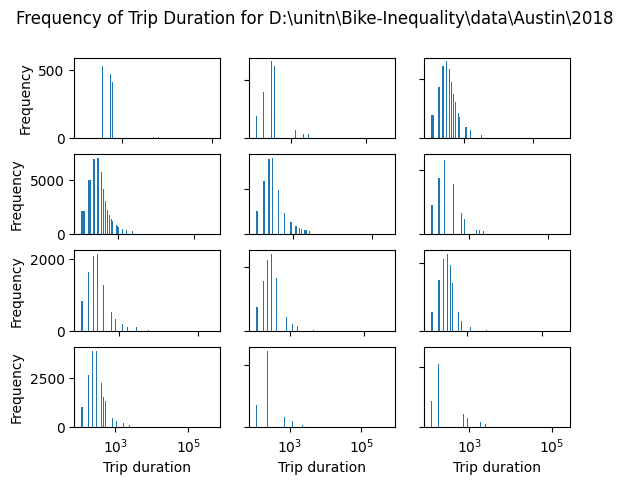

Year: 2019


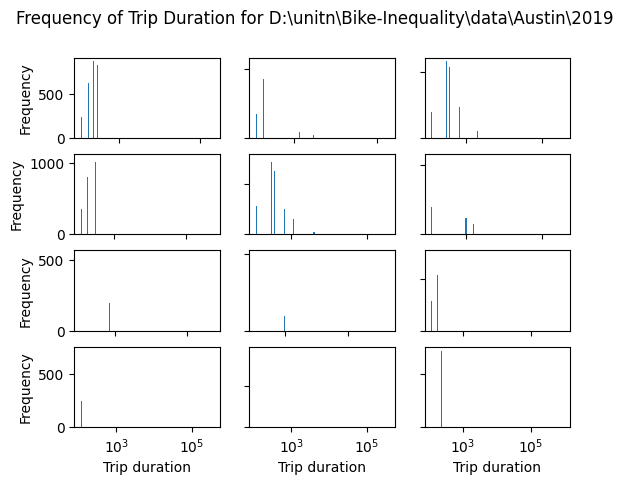

Year: 2020


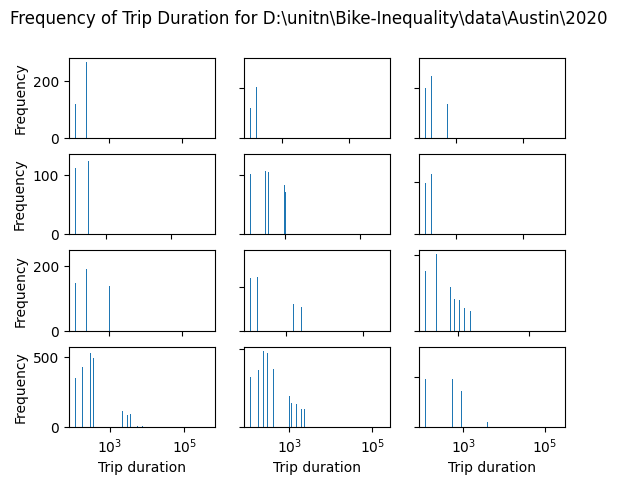

Year: 2021


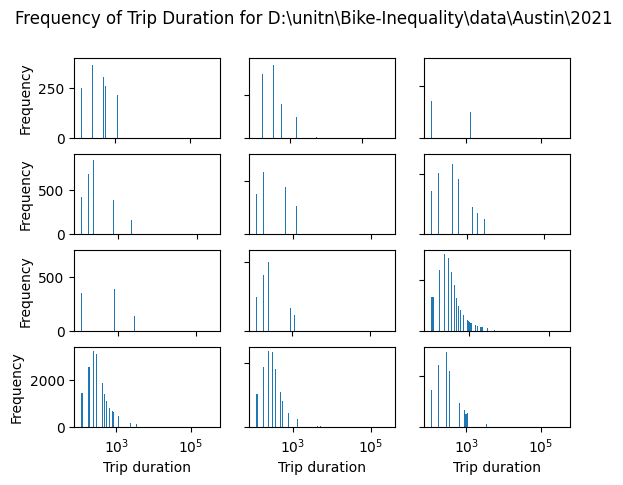

Year: 2022


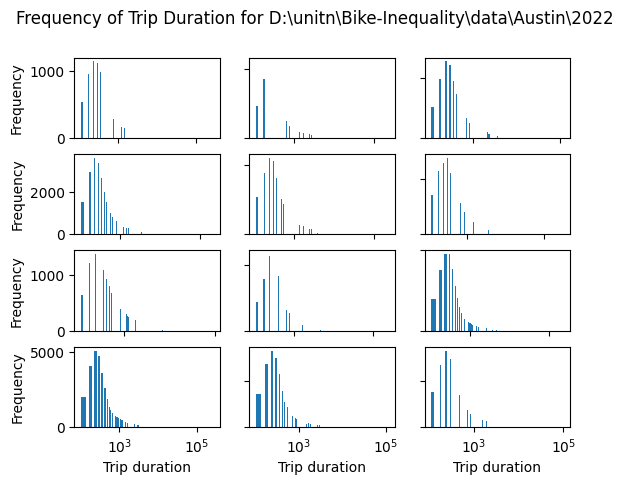

Year: 2023


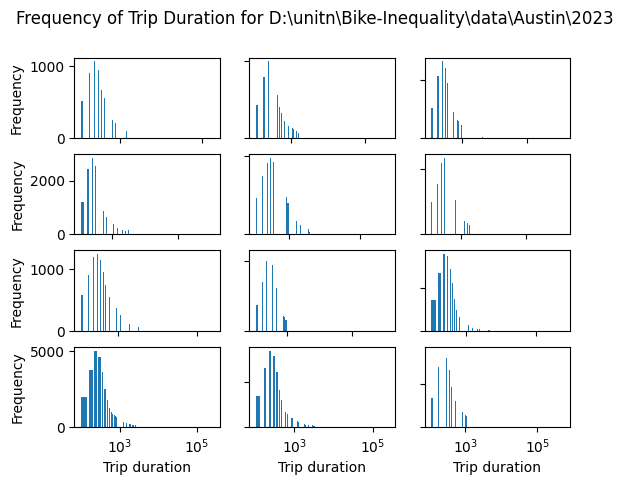

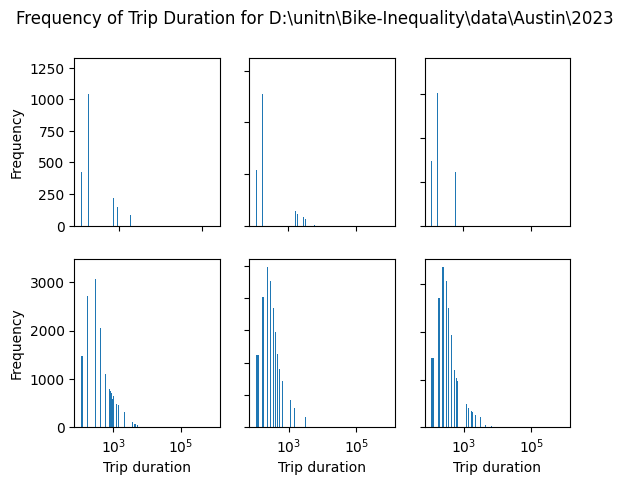

Gender data not available in this city: itn\Bike-Inequality\data\Austin


NameError: name 'remove_zeros' is not defined

In [8]:
for file in os.listdir(data_dir):
    print('City:', file)
    data_dir_city = os.path.join(data_dir, file)
    
    # plot date for each month
    for year in os.listdir(data_dir_city):
        print('Year:', year)
        data_dir_city_year = os.path.join(data_dir_city, year)
        data_for_month(data_dir_city_year)
    
    data_for_year(data_dir_city)
    data_for_gender(data_dir_city)
    data_for_usertype(data_dir_city)